## 3 層 Deeplerning で過学習させてみる

実際過学習がどの程度影響するのかを検証してみる。  
ニューロンのひな型は [このへん](https://white-azalea.hatenablog.jp/entry/2021/03/08/234643) で作ったものを流用。

In [1]:
import numpy as np

wb_width = 0.1  # 重みとバイアスの広がり方
eta = 0.01      # 学習係数

class Neuron:
    def __init__(self, n_upper, n, activation_function, differential_function):
        self.w = wb_width * np.random.randn(n_upper, n) # ランダムなのが確立勾配法
        self.b = wb_width * np.random.randn(n)
        self.grad_w = np.zeros((n_upper, n))
        self.grad_b = np.zeros((n))
        self.activation_function = activation_function
        self.differential_function = differential_function

    def update(self):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
    
    def forward(self, x):
        self.x = x
        u = x.dot(self.w) + self.b
        self.y = self.activation_function(u)
        return self.y

    def backword(self, t):
        delta = self.differential_function(self.y, t)
        self.grad_w = self.x.T.dot(delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = delta.dot(self.w.T)
        return self.grad_x
    
    def show(self):
        print(json.dumps(self.w.tolist()))
        print(json.dumps(self.b.tolist()))


class Output(Neuron):
    pass


class Middle(Neuron):
    def backword(self, grad_y):
        delta = self.differential_function(grad_y, self.y)
        self.grad_w = self.x.T.dot(delta)
        self.grad_b = delta.sum(axis = 0)
        self.grad_x = delta.dot(self.w.T)
        return self.grad_x

活性関数は ReLU で、出力層にはソフトマックス関数を利用。  
損失関数には交差エントロピーを使う。（最適化には確率的勾配降下法）

前回は2層（中間層8＋出力層3）で過学習らしい話はなかったので、今回はわざと中間層ニューロンを 25 個とかにする。

In [2]:
def relu_func(x):
    return np.where(x <= 0, 0, x)

def relu_func_dash(y, t):
    return y * np.where(t <= 0, 0, 1)

def soft_max(u):
    return np.exp(u) / np.sum(np.exp(u), axis=1, keepdims = True)

def soft_max_dash(y, t):
    return y - t

n_in  = 4
n_mid = 25
n_out = 3
mid_layer1 = Middle(n_in, n_mid, relu_func, relu_func_dash)
mid_layer2 = Middle(n_mid, n_mid, relu_func, relu_func_dash)
outputs = Output(n_mid, n_out, soft_max, soft_max_dash)

def forward_propagation(x):
    return outputs.forward(mid_layer2.forward(mid_layer1.forward(x)))


def back_propagation(t):
    mid_layer1.backword(mid_layer2.backword(outputs.backword(t)))


def update():
    mid_layer1.update()
    mid_layer2.update()
    outputs.update()


def get_err(result, t, batch_size):
    """交差エントロピー誤差"""
    return -np.sum(t * np.log(result + 1e-7)) / batch_size

では、分かりやすくデータセットを読み込もう

In [3]:
from sklearn import datasets


iris_data    = datasets.load_iris()
input_data   = iris_data.data
correct_data = iris_data.target
n_data       = len(correct_data)

データを標準化( [式はこの辺から取得](https://white-azalea.hatenablog.jp/entry/2021/03/15/225444) )して 

In [4]:
def standardize(x):
    av = np.average(x, axis=0)
    std = np.std(x, axis=0)
    return (x - av) / std


input_data = standardize(input_data)

結果も on-hot 表現にしようか。

In [5]:
def to_one_hot(v):
    if v == 0:
        return [1, 0, 0]
    elif v == 1:
        return [0, 1, 0]
    else:
        return [0, 0, 1]

correct_data = np.array([to_one_hot(v) for v in correct_data])

Iris データを教師データと検証データに分離。

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(input_data, correct_data, random_state=0)

# データ数
n_train = X_train.shape[0]
n_test  = X_test.shape[0]

print(f'Training: {n_train} and Tests: {n_test}')

Training: 112 and Tests: 38


いざ尋常に…一本目…勝負！（ミニバッチで試行）

In [7]:
epoch      = 1000
batch_size = 8
interval   = 100
n_batch = n_train // batch_size  # バッチ/エポック

# 誤差記録用
train_err_x = []
train_err_y = []
test_err_x = []
test_err_y = []

n_in  = 4
n_mid = 25
n_out = 3
mid_layer1 = Middle(n_in, n_mid, relu_func, relu_func_dash)
mid_layer2 = Middle(n_mid, n_mid, relu_func, relu_func_dash)
outputs = Output(n_mid, n_out, soft_max, soft_max_dash)

def exec():
    for i in range(epoch):
        # 誤差測定
        x_res = forward_propagation(X_train)
        err_train = get_err(x_res, y_train, n_train)
        y_res = forward_propagation(X_test)
        err_test = get_err(y_res, y_test, n_test)

        train_err_x.append(i)
        train_err_y.append(err_train)
        test_err_x.append(i)
        test_err_y.append(err_test)

        # 途中経過
        if i % interval == 0:
            print(f'Epoch: {i} / {epoch}, Err_train: {err_train}, Err_test: {err_test}')
        
        # 学習
        # ランダムなインデックス生成
        random_indexes = np.arange(n_train)
        np.random.shuffle(random_indexes)
        for j in range(n_batch):
            # バッチ単位でデータ取得
            mb_indexes = random_indexes[j * batch_size : (j+1) * batch_size]
            x = X_train[mb_indexes, :]
            t = y_train[mb_indexes, :]

            # フォワード/バック/学習
            forward_propagation(x)
            back_propagation(t)
            update()

exec()

Epoch: 0 / 1000, Err_train: 1.1188678725088852, Err_test: 1.0741287845797183
Epoch: 100 / 1000, Err_train: 0.022156452346814733, Err_test: 0.09437069784152875
Epoch: 200 / 1000, Err_train: 0.009053804027720418, Err_test: 0.18885028835742923
Epoch: 300 / 1000, Err_train: 0.0069379617839766105, Err_test: 0.21728744760885677
Epoch: 400 / 1000, Err_train: 0.0021000353306268823, Err_test: 0.2657830359289565
Epoch: 500 / 1000, Err_train: 0.001363432803194363, Err_test: 0.2931972571973713
Epoch: 600 / 1000, Err_train: 0.0009618036538362834, Err_test: 0.3163168971352748
Epoch: 700 / 1000, Err_train: 0.0007259607208371508, Err_test: 0.32935992577710727
Epoch: 800 / 1000, Err_train: 0.0005821356710873422, Err_test: 0.34061422861356483
Epoch: 900 / 1000, Err_train: 0.00048006676240412764, Err_test: 0.3519300595577461


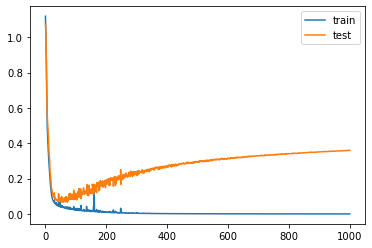

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_err_x, train_err_y, label='train')
plt.plot(test_err_x, test_err_y, label='test')
plt.legend()

回を重ねるごとに、学習データ「train」への適合が安定化して、代わりに test　の誤差が広がっていく。  
完全に過学習です。本当にありがとうございましたｗｗｗ

これ 100 エポ位で安定するんじゃね？ってことでやってみる。

Epoch: 0 / 101, Err_train: 1.0909844681262997, Err_test: 1.0935299757257546
Epoch: 100 / 101, Err_train: 0.023856923210835854, Err_test: 0.08876070774965812


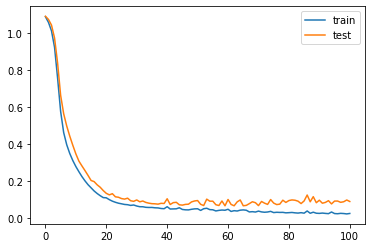

In [21]:
epoch      = 101
batch_size = 8
interval   = 100
n_batch = n_train // batch_size  # バッチ/エポック

train_err_x = []
train_err_y = []
test_err_x = []
test_err_y = []

# 学習をリセット
n_in  = 4
n_mid = 25
n_out = 3
mid_layer1 = Middle(n_in, n_mid, relu_func, relu_func_dash)
mid_layer2 = Middle(n_mid, n_mid, relu_func, relu_func_dash)
outputs = Output(n_mid, n_out, soft_max, soft_max_dash)

# やってみる
exec()

plt.plot(train_err_x, train_err_y, label='train')
plt.plot(test_err_x, test_err_y, label='test')
plt.legend()

単純にニューロン多すぎだと思うので、8 個まで減らす

Epoch: 0 / 200, Err_train: 1.099739783969061, Err_test: 1.097925082672353
Epoch: 100 / 200, Err_train: 0.03231367491185859, Err_test: 0.0784704116756018


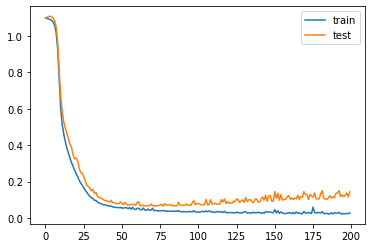

In [20]:
epoch      = 200
batch_size = 8
interval   = 100
n_batch = n_train // batch_size  # バッチ/エポック

train_err_x = []
train_err_y = []
test_err_x = []
test_err_y = []

# 学習をリセット
n_in  = 4
n_mid = 8
n_out = 3
mid_layer1 = Middle(n_in, n_mid, relu_func, relu_func_dash)
mid_layer2 = Middle(n_mid, n_mid, relu_func, relu_func_dash)
outputs = Output(n_mid, n_out, soft_max, soft_max_dash)

# やってみる
exec()

plt.plot(train_err_x, train_err_y, label='train')
plt.plot(test_err_x, test_err_y, label='test')
plt.legend()

減らしたところで感…ハイパーパラメータ(定数)弄っての最適化にはそこそこ限度がありそうな感じ